<a href="https://colab.research.google.com/github/alicevadney/labs/blob/main/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1

In [3]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()

To clean the data, I would remove special characters, like punctuation, and common words, such as "and", "the" and "a/an". Then, I would make each token a predictor (1 for presence and 0 for missing) to measure the existence of a given word in a scam email. This would allow for an algorithm to use the presence/lack of a token to predict whether an email is a scam.

## Question 2

In [8]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

<Axes: >

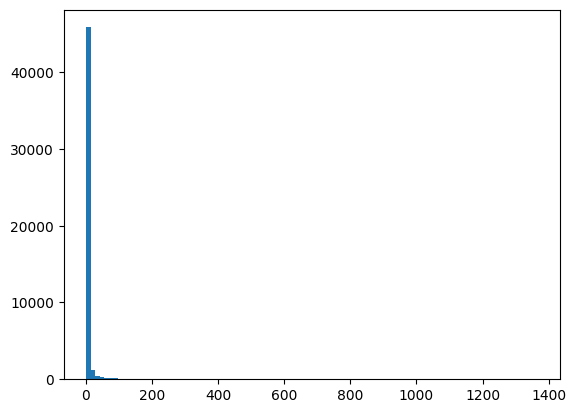

In [9]:
df1 = pd.DataFrame(token_freq,columns=['token','count'])
df1['count'].hist(grid=False,bins=100)

It appears that most tokens appear only once, with a small number appearing a few more times. From the bounds of the graph, it appears that a token appears over 1000 times, but there are not enough of them to appear on the graph to the viewer.

## Question 3

In [15]:
df = pd.read_parquet('Phishing_clean.parquet', engine='pyarrow') # got code from Gemini
y = df['Email Type']
X = df.drop('Email Type',axis=1)

# part 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

# part 2
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train R^2: ', r2_score(y_hat_train_0,y_train) )
print('test R^2: ', r2_score(y_hat_test_0,y_test) )

# part 3
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

train R^2:  0.6210107280960204
test R^2:  -0.00026838432670373


,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The most popular words are numbers, which is not super helpful because numbers are pretty common in all emails.

## Question 4

<Axes: >

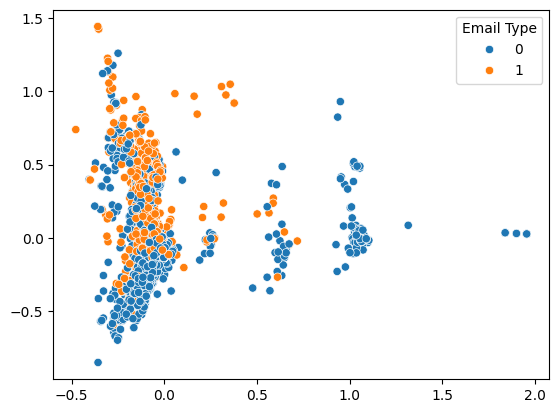

In [18]:
reduction = PCA(n_components=2).fit(X_train)

Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

sns.scatterplot(x=Z_test[:,0], y=Z_test[:,1], hue=y_test)

The scam points appear to have a lower first component and higher second component than the other points.

# Question 5

In [20]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('train R^2: ', r2_score(y_hat_train,y_train) )
print('test R^2: ', r2_score(y_hat_test,y_test) )

train R^2:  0.692897536096375
test R^2:  0.5873905973217184


This performs better than the linear regression. The test R^2 is 0.587 as compared to practically 0 in the linear model.

# Question 6

One advantage is that multicollinearity doesn't occur. PCA also removes noise by reducing the number of dimensions in the data.

A drawback is that we cannot interpret what the components are because the initial variables are transformed in the process. Another is the large impact that outliers can make on the model.